# **Question/Answering system over SQL data**
Enabling a LLM system to query structured data can be qualitatively different from unstructured text data. Whereas in the latter it is common to generate text that can be searched against a vector database, the approach for structured data is often for the LLM to write and execute queries in a DSL, such as SQL. In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. We will cover implementations using both chains and agents. These systems will allow us to ask a question about the data in a database and get back a natural language answer. The main difference between the two is that our agent can query the database in a loop as many times as it needs to answer the question.

## **⚠️ Security note ⚠️**
Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your chain/agent's needs. This will mitigate though not eliminate the risks of building a model-driven system. For more on general security best practices, see here.

## **Architecture**
At a high-level, the steps of these systems are:

1. **Convert question to SQL query:** Model converts user input to a SQL query.
2. **Execute SQL query:** Execute the query.
3. **Answer the question:** Model responds to user input using the query results.

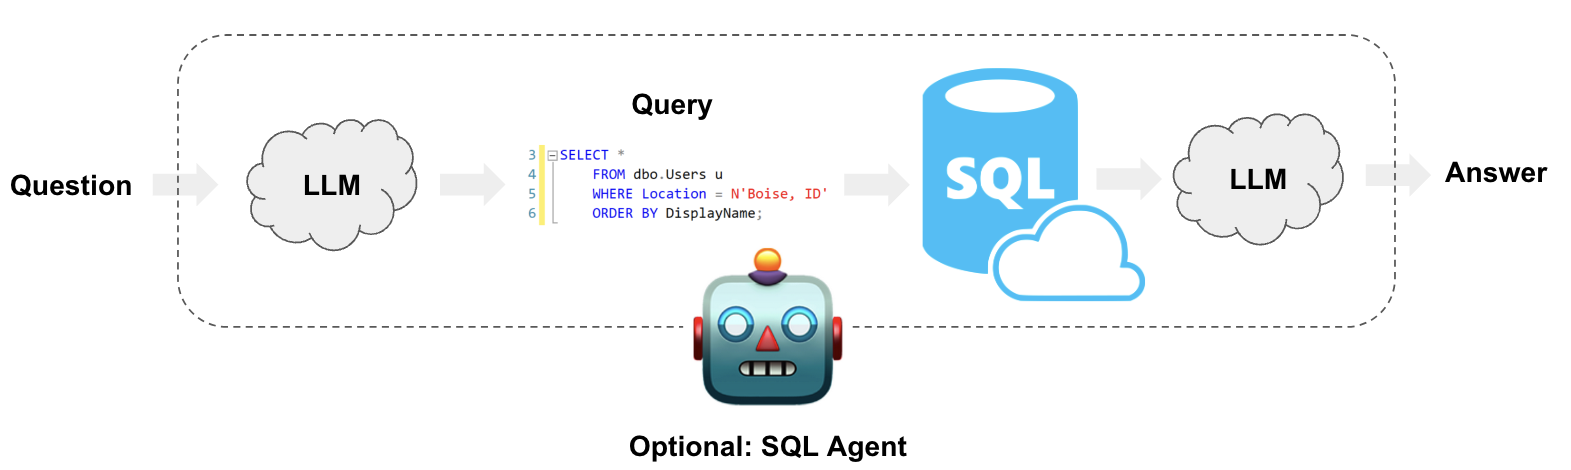

## Get required packages

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langchainhub langchain-ollama langgraph colab-xterm faiss-cpu

In [2]:
!apt-get update && apt-get install -y sqlite3

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [68.9 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,338 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,708 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

## Imports

In [3]:
import faiss
from uuid import uuid4
from langchain import hub
from typing import Dict, Any
from langchain_ollama import ChatOllama
from IPython.display import Image, display
from langgraph.graph import START, StateGraph
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from typing_extensions import TypedDict, Annotated
from langchain.chains import create_sql_query_chain
from langchain_community.utilities import SQLDatabase
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_core.example_selectors import SemanticSimilarityExampleSelector

## Get Sample data

In [4]:
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

Now, `Chinook.db` is in our directory and we can interface with it using the SQLAlchemy-driven `SQLDatabase` class:

In [5]:
# Connect to the SQLite database "Chinook.db" using its URI
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [6]:
# Print the SQL dialect (e.g., "sqlite") used by the connected database
print(db.dialect)

sqlite


In [7]:
# Print a list of table names available for use in the database
print(db.get_usable_table_names())

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [8]:
# Execute a SQL query
print(db.run("SELECT * FROM TRACK LIMIT 10;"))

[(1, 'For Those About To Rock (We Salute You)', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 343719, 11170334, 0.99), (2, 'Balls to the Wall', 2, 2, 1, 'U. Dirkschneider, W. Hoffmann, H. Frank, P. Baltes, S. Kaufmann, G. Hoffmann', 342562, 5510424, 0.99), (3, 'Fast As a Shark', 3, 2, 1, 'F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman', 230619, 3990994, 0.99), (4, 'Restless and Wild', 3, 2, 1, 'F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman', 252051, 4331779, 0.99), (5, 'Princess of the Dawn', 3, 2, 1, 'Deaffy & R.A. Smith-Diesel', 375418, 6290521, 0.99), (6, 'Put The Finger On You', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 205662, 6713451, 0.99), (7, "Let's Get It Up", 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 233926, 7636561, 0.99), (8, 'Inject The Venom', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 210834, 6852860, 0.99), (9, 'Snowballed', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 203102, 6599424, 0.

API Reference:[SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html)

# 1. **Chains**
Chains are compositions of predictable steps. In [LangGraph](https://python.langchain.com/docs/concepts/architecture/#langgraph), we can represent a chain via simple sequence of nodes. Let's create a sequence of steps that, given a question, does the following:

1. converts the question into a SQL query;
2. executes the query;
3. uses the result to answer the original question.


There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input-- even "hello". Importantly, as we'll see below, some questions require more than one query to answer. We will address these scenarios in the Agents section.

### a) [Application state](https://)

The LangGraph state of our application controls what data is input to the application, transferred between steps, and output by the application.

For this application, we can just keep track of the input question, generated query, query result, and generated answer:

In [9]:
class State(TypedDict):
  question: str
  sql_query: str
  query_result: str
  llm_response: str

### b) [Convert question to SQL query](https://)

The first step is to take the user input and convert it to a SQL query. To reliably obtain SQL queries (absent markdown formatting and explanations or clarifications), we will make use of LangChain's [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) abstraction.

#### **Select [chat model](https://python.langchain.com/docs/integrations/chat/):**

### **Running Ollama Locally on Google Colab**  

Ollama allows you to run large language models (LLMs) locally within a Google Colab environment. Below are the steps to install and run it efficiently.  

#### **1. Install Ollama**  
Run the following command in a Colab cell to install Ollama:  
```python
!curl -fsSL https://www.ollama.com/install.sh | sh
```

#### **2. Start Ollama as a Background Service**  
Once installed, start the Ollama server in the background:  
```python
!nohup ollama serve &
```
This will keep Ollama running in the background even after the cell execution completes. You may see a message:  
```bash
nohup: appending output to 'nohup.out'
```
This indicates that all terminal output is being logged to the `nohup.out` file.

#### **3. Verify Ollama is Running**  
Check if Ollama is running by listing available models:  
```python
!ps -aux | grep 'ollama serve'
```

#### **4. Download a Model**  
Now that Ollama is running, pull a model using:  
```python
!ollama pull mistral
```
Once installed, you can use Ollama within your Colab notebook to run local LLMs efficiently.

---

### **Checking Ollama Logs**  
All terminal output from Ollama is logged in `nohup.out`. You can check the logs using the following commands:  
```python
!cat nohup.out       # Displays the entire log file  
!head -n 20 nohup.out  # Shows the first 20 lines  
!tail -n 20 nohup.out  # Shows the last 20 lines  
```

These commands help you quickly inspect the logs without opening the file.

---

In [10]:
!curl -fsSL https://www.ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [11]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


To confirm that the `ollama serve` process is running in the background, you can list active processes using:

In [12]:
!ps -aux | grep 'ollama serve'

root        2115  0.6  0.3 6530136 40496 ?       Sl   03:21   0:00 ollama serve
root        2231  0.0  0.0   6484  2280 ?        S    03:21   0:00 grep ollama serve


In [13]:
!ollama list

NAME    ID    SIZE    MODIFIED 


In [ ]:
# Pull the "qwen2.5:14b" model from Ollama's repository
!ollama pull qwen2.5:14b

In [15]:
llm = ChatOllama(
    model="qwen2.5:14b",
    temperature=0,         # Controls randomness; lower values are more deterministic
    max_tokens=1024,       # Maximum length of the generated response
    top_p=0.5,             # Nucleus sampling parameter for token diversity
    frequency_penalty=0.0, # Penalizes frequent token repetition
    presence_penalty=0.0  # Penalizes new tokens based on whether they appear in the text so far
)

In [16]:
await llm.ainvoke("Hey!!")

AIMessage(content='Hello there! How can I assist you today? Feel free to ask any questions or let me know if you need help with anything.', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-03-04T03:24:33.298034731Z', 'done': True, 'done_reason': 'stop', 'total_duration': 42178049241, 'load_duration': 39207759052, 'prompt_eval_count': 31, 'prompt_eval_duration': 822000000, 'eval_count': 28, 'eval_duration': 1429000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-1dac9e8a-93fc-40a0-ae23-9a6005fbf36e-0', usage_metadata={'input_tokens': 31, 'output_tokens': 28, 'total_tokens': 59})

In [17]:
!tail -n 20 nohup.out

llm_load_print_meta: general.name     = Qwen2.5 14B Instruct
llm_load_print_meta: BOS token        = 151643 '<|endoftext|>'
llm_load_print_meta: EOS token        = 151645 '<|im_end|>'
llm_load_print_meta: EOT token        = 151645 '<|im_end|>'
llm_load_print_meta: PAD token        = 151643 '<|endoftext|>'
llm_load_print_meta: LF token         = 148848 'ÄĬ'
llm_load_print_meta: FIM PRE token    = 151659 '<|fim_prefix|>'
llm_load_print_meta: FIM SUF token    = 151661 '<|fim_suffix|>'
llm_load_print_meta: FIM MID token    = 151660 '<|fim_middle|>'
llm_load_print_meta: FIM PAD token    = 151662 '<|fim_pad|>'
llm_load_print_meta: FIM REP token    = 151663 '<|repo_name|>'
llm_load_print_meta: FIM SEP token    = 151664 '<|file_sep|>'
llm_load_print_meta: EOG token        = 151643 '<|endoftext|>'
llm_load_print_meta: EOG token        = 151645 '<|im_end|>'
llm_load_print_meta: EOG token        = 151662 '<|fim_pad|>'
llm_load_print_meta: EOG token        = 151663 '<|repo_name|>'
llm_load_print_m

We will pull a prompt from the [Prompt Hub](https://smith.langchain.com/hub) to instruct the model.

In [18]:
sql_prompt = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(sql_prompt.messages) == 1
sql_prompt.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [18]:
class OutputFormat(TypedDict):
    """
    A dictionary type representing the output of an SQL query generation process.

    Attributes:
        sql_query (str): A syntactically correct SQL query generated by the system.
    """
    sql_query: Annotated[
        str,
        ...,
        "A valid SQL query string that adheres to proper SQL syntax."
    ]



async def generate_sql_query(state: State):
    """
    Generate a syntactically correct SQL query based on the user's question and current database schema.

    Args:
        state (State): A dictionary containing user context. It must include the key 'question' with the user's query.

    Returns:
        dict: A dictionary with a single key "sql_query" whose value is the generated SQL query.
    """
    try:
        # Construct the prompt using the database dialect, table metadata, and the user's question.
        prompt_parameters = {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"]
        }
        prompt = sql_prompt.invoke(prompt_parameters)

        # Set up the LLM to generate output in a structured format matching OutputFormat.
        structured_llm = llm.with_structured_output(OutputFormat, method="json_schema")

        # Asynchronously generate the SQL query using the structured LLM.
        generated_sql = await structured_llm.ainvoke(prompt)

        # Return the generated SQL query in a dictionary.
        return {"sql_query": generated_sql["sql_query"]}

    except Exception as error:
        # logging the error for debugging.
        raise RuntimeError("Error generating SQL query.") from error


**Let's test it out:**

In [ ]:
response = await generate_sql_query({"question": "Give list of all tracks!"})
response

{'sql_query': 'SELECT TrackId, Name FROM Track LIMIT 10;'}

In [ ]:
# Execute the SQL query using the database's run method
query_results = db.run(response["sql_query"])

# Print the results
print(f"Executed SQL query results: {query_results}")

Executed SQL query results: [(1, 'For Those About To Rock (We Salute You)', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 343719, 11170334, 0.99), (2, 'Balls to the Wall', 2, 2, 1, 'U. Dirkschneider, W. Hoffmann, H. Frank, P. Baltes, S. Kaufmann, G. Hoffmann', 342562, 5510424, 0.99), (3, 'Fast As a Shark', 3, 2, 1, 'F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman', 230619, 3990994, 0.99), (4, 'Restless and Wild', 3, 2, 1, 'F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman', 252051, 4331779, 0.99), (5, 'Princess of the Dawn', 3, 2, 1, 'Deaffy & R.A. Smith-Diesel', 375418, 6290521, 0.99), (6, 'Put The Finger On You', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 205662, 6713451, 0.99), (7, "Let's Get It Up", 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 233926, 7636561, 0.99), (8, 'Inject The Venom', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 210834, 6852860, 0.99), (9, 'Snowballed', 1, 1, 1, 'Angus Young, Malcolm Young, Brian J

In [ ]:
response = await generate_sql_query({"question": "What are the distinct genres of tracks in our database?"})
response

{'sql_query': 'SELECT DISTINCT Name FROM Genre;'}

In [ ]:
# Execute the SQL query using the database's run method
query_results = db.run(response["sql_query"])

# Print the results
print(f"Executed SQL query results: {query_results}")

Executed SQL query results: [('Rock',), ('Jazz',), ('Metal',), ('Alternative & Punk',), ('Rock And Roll',), ('Blues',), ('Latin',), ('Reggae',), ('Pop',), ('Soundtrack',), ('Bossa Nova',), ('Easy Listening',), ('Heavy Metal',), ('R&B/Soul',), ('Electronica/Dance',), ('World',), ('Hip Hop/Rap',), ('Science Fiction',), ('TV Shows',), ('Sci Fi & Fantasy',), ('Drama',), ('Comedy',), ('Alternative',), ('Classical',), ('Opera',)]


### c) [Execute query](https://)

⚠️⚠️ This is the most dangerous part of creating a SQL chain. Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution.

To execute the query, we will load a tool from langchain-community. Our `execute_query` node will just wrap this tool:

In [ ]:
async def execute_query(state: State):
    """
    Execute the SQL query provided in the state.

    This function retrieves the SQL query from the given state dictionary and
    uses the QuerySQLDatabaseTool to execute the query asynchronously.

    Args:
        state (State): A dictionary that must contain the key 'sql_query'
                       with the SQL statement to be executed.

    Returns:
        Any: The result of executing the SQL query.

    Raises:
        ValueError: If 'sql_query' is missing in the state.
        RuntimeError: If query execution fails.
    """
    # Validate that the SQL query is provided.
    if "sql_query" not in state:
        raise ValueError("Missing 'sql_query' in state.")

    # Initialize the query tool with the current database connection.
    query_tool = QuerySQLDatabaseTool(db=db)

    try:
        # Asynchronously execute the SQL query.
        query_results = await query_tool.ainvoke(state["sql_query"])
    except Exception as error:
        # Optionally, log the error for debugging purposes.
        raise RuntimeError("Failed to execute SQL query.") from error

    return {"query_result": query_results}

**[Let's test it out:](https://)**

In [ ]:
await execute_query({"sql_query": 'SELECT DISTINCT g.Name FROM Genre AS g JOIN Track AS t ON g.GenreId = t.GenreId;'})

{'query_result': "[('Rock',), ('Jazz',), ('Metal',), ('Alternative & Punk',), ('Rock And Roll',), ('Blues',), ('Latin',), ('Reggae',), ('Pop',), ('Soundtrack',), ('Bossa Nova',), ('Easy Listening',), ('Heavy Metal',), ('R&B/Soul',), ('Electronica/Dance',), ('World',), ('Hip Hop/Rap',), ('Science Fiction',), ('TV Shows',), ('Sci Fi & Fantasy',), ('Drama',), ('Comedy',), ('Alternative',), ('Classical',), ('Opera',)]"}

#### **Manual Query Execution vs. Using a Dedicated Query Tool**

You can run SQL queries directly—for example, by simply calling `db.run('SQL query')`—and create an `execute_query` function that uses this method. For example:


In [ ]:
import asyncio
from typing import Any

async def execute_query_manual(state: State) -> Any:
    """
    Manually execute the SQL query using the db.run() method.

    This function retrieves the SQL query from the state dictionary, then
    runs it using the synchronous db.run() function in an executor so that
    the call does not block the event loop.

    Args:
        state (State): A dictionary that must include the key 'sql_query'
                       containing the SQL statement to execute.

    Returns:
        Any: The result returned from executing the SQL query.

    Raises:
        ValueError: If 'sql_query' is missing in the state.
        RuntimeError: If the query execution fails.
    """
    # Check if the SQL query is provided in the state.
    if "sql_query" not in state:
        raise ValueError("Missing 'sql_query' in state.")

    sql_query = state["sql_query"]

    # Use the default executor to run the blocking db.run() method asynchronously.
    loop = asyncio.get_event_loop()
    try:
        query_results = await loop.run_in_executor(None, db.run, sql_query)
    except Exception as error:
        # Optionally, log the error here.
        raise RuntimeError("Manual query execution failed.") from error

    return query_results

In [ ]:
await execute_query_manual({"sql_query": 'SELECT DISTINCT g.Name FROM Genre AS g JOIN Track AS t ON g.GenreId = t.GenreId;'})

"[('Rock',), ('Jazz',), ('Metal',), ('Alternative & Punk',), ('Rock And Roll',), ('Blues',), ('Latin',), ('Reggae',), ('Pop',), ('Soundtrack',), ('Bossa Nova',), ('Easy Listening',), ('Heavy Metal',), ('R&B/Soul',), ('Electronica/Dance',), ('World',), ('Hip Hop/Rap',), ('Science Fiction',), ('TV Shows',), ('Sci Fi & Fantasy',), ('Drama',), ('Comedy',), ('Alternative',), ('Classical',), ('Opera',)]"

However, using a dedicated tool like `QuerySQLDatabaseTool` provides several advantages:
- **Consistency:** It standardizes how queries are executed across your application.
- **Asynchronous Integration:** Designed to work seamlessly in async workflows.
- **Enhanced Functionality:** It can include built-in error handling, logging, caching, etc.
- **Abstraction:** It hides low-level details, resulting in cleaner, more maintainable code.

While the manual approach works, the tool-based method is more robust and scalable for larger systems.

### d) [Generate answer](https://)

In [ ]:
async def generate_answer(state: State):
    """
    Generate a human-readable answer based on the user's question, the SQL query,
    and the corresponding query results.

    Args:
        state (State): A dictionary containing:
            - "question": The user's question.
            - "sql_query": The SQL query generated to retrieve relevant data.
            - "query_result": The result obtained from executing the SQL query.

    Returns:
        dict: A dictionary with the key "llm_response" containing the generated answer.
    """
    # Construct a prompt with the context needed for generating an answer.
    prompt = (
        "Generate an easy-to-understand answer based on the following information:\n\n"
        f"User Question: {state['question']}\n"
        f"SQL Query: {state['sql_query']}\n"
        f"SQL Query Results: {state['query_result']}"
    )

    # Asynchronously invoke the language model to generate the answer.
    response = await llm.ainvoke(prompt)

    # Return the LLM's response content.
    return {"llm_response": response.content}

**Testing this step:**

In [ ]:
question = "Retrieve the total number of customers."

sql_query = await generate_sql_query({
    "question": question
})

query_results = await execute_query({
    "sql_query": sql_query['sql_query']
})

await generate_answer({
    "question": question,
    "sql_query": sql_query['sql_query'],
    "query_result": query_results
})

{'llm_response': 'The total number of customers is 59.'}

## e) [Orchestrating with LangGraph](https://)

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the three steps into a single sequence.

In [ ]:
graph_builder = StateGraph(state_schema=State).add_sequence([
    generate_sql_query,
    execute_query,
    generate_answer
])

graph_builder.add_edge(START, "generate_sql_query")

graph = graph_builder.compile()

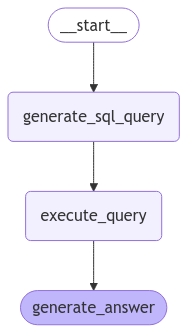

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application! Note that we can stream the results of individual steps:

In [ ]:
query = "How many employees are there?"

async for step in graph.astream(
    {"question": query},
    stream_mode="updates"
):
    print(step)

{'generate_sql_query': {'sql_query': 'SELECT COUNT(*) AS employee_count FROM Employee;'}}
{'execute_query': {'query_result': '[(8,)]'}}
{'generate_answer': {'llm_response': 'There are 8 employees in total.'}}


## f) [Human-in-the-loop](https://)

LangGraph supports a number of features that can be useful for this workflow. One of them is [human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/): we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review.

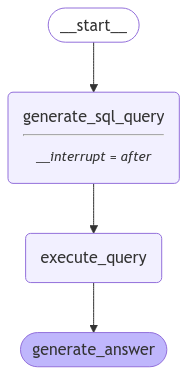

In [ ]:
# Create an in-memory saver to store execution checkpoints.
memory = InMemorySaver()

# Compile the graph with the following options:
# - 'checkpointer' saves intermediate states using the in-memory saver.
# - 'interrupt_after' pauses the process after completing the 'generate_sql_query' step.
graph_htl = graph_builder.compile(
    checkpointer=memory,
    interrupt_after=["generate_sql_query"]
)

# Retrieve the graph, convert it into a Mermaid diagram PNG, and display it.
display(Image(graph_htl.get_graph().draw_mermaid_png()))

Let's repeat the same run, adding in a simple yes/no approval step:

In [ ]:
# Define the configuration with a specific thread ID.
config = {"configurable": {"thread_id": "1"}}

# Define the SQL query to be generated.
query = "How many tracks are there?"

# Generate and print each update from the SQL query generation process.
print("Generating SQL query updates...")
async for step in graph_htl.astream({"question": query}, config=config, stream_mode="updates"):
    print(step)

# Prompt the user for approval to execute the generated SQL query.
try:
    user_input = input(
        "Please review the generated SQL query and confirm whether you'd like it executed by replying 'Yes' or 'No': "
    )
    user_approval = user_input.strip().lower()
except Exception as e:
    print(f"An error occurred while reading input: {e}")
    user_approval = "no"

# Check the user's response and act accordingly.
if user_approval == "yes":
    print("User approval received. Executing SQL query...")
    async for step in graph_htl.astream(None, config, stream_mode="updates"):
        print(step)
else:
    print("User approval denied. The SQL query will not be executed.")


Generating SQL query updates...
{'generate_sql_query': {'sql_query': 'SELECT COUNT(*) AS track_count FROM Track;'}}
{'__interrupt__': ()}
Please review the generated SQL query and confirm whether you'd like it executed by replying 'Yes' or 'No': YEs
User approval received. Executing SQL query...
{'execute_query': {'query_result': '[(3503,)]'}}
{'generate_answer': {'llm_response': 'There are 3503 tracks in total.'}}


**Next Steps**  

If we need to generate more complex queries, we might want to use few-shot prompts or add query-checking steps. For more advanced techniques, let's
 check out:  

- <a href="#scrollTo=1b4Av84h-t34" target="_self">Prompting Strategies</a> – Advanced prompt engineering techniques to refine query generation.  
- **Query Validation** – Methods to check queries for errors and ensure accuracy.  
- **Scaling for Large Databases** – Best practices for handling massive datasets efficiently.  

Let’s explore these as we refine our approach! 🚀

# 2. **How to better prompt when doing SQL question-answering**

Let’s dive into some strategies for improving SQL query generation. The main focus here is on getting the right database-specific details into your prompt to improve accuracy and relevance.  

Here’s what we’ll cover:  

- How the LangChain [SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) dialect affects the chain’s prompt.  
- The best way to format schema details using `SQLDatabase.get_context`.  
- Selecting and structuring [few-shot examples](https://python.langchain.com/docs/concepts/few_shot_prompting/) to guide the model effectively.  

Let’s get into it.

## a) [Dialect-specific prompting]()

One of the easiest ways to improve query generation is by tailoring the prompt to the specific SQL dialect in use. LangChain takes care of this automatically for the following dialects:

In [ ]:
from langchain.chains.sql_database.prompt import SQL_PROMPTS

list(SQL_PROMPTS)

['crate',
 'duckdb',
 'googlesql',
 'mssql',
 'mysql',
 'mariadb',
 'oracle',
 'postgresql',
 'sqlite',
 'clickhouse',
 'prestodb']

For instance, with our current database, we'll need to use a prompt tailored specifically for SQLite.

In [ ]:
SQL_PROMPTS['sqlite'].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: 

#### **For `create_sql_query_chain` (Built-in Chain):**

Generates SQL queries for the given database.

When using `create_sql_query_chain`, we only need to pass the database connection (`db`). With our current database, we receive a SQLite-specific prompt.

In [ ]:
db.dialect

'sqlite'

In [ ]:
sql_chain = create_sql_query_chain(llm, db)
sql_chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

#### **For Custom-Built SQL Chain:**

Unlike `create_sql_query_chain`, where the SQL prompt is automatically adapted to your database dialect, in a custom-built chain, you must manually select the SQL prompt specific to your database dialect and provide the necessary inputs accordingly.

In [ ]:
dialect_secific_prompt = SQL_PROMPTS['sqlite']
prompt_parameters = {
    "top_k": 10,
    "table_info": '',
    "input": "how many artists are there?"
        }
compiled_prompt = dialect_secific_prompt.invoke(prompt_parameters)
print(compiled_prompt.text)

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 10 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Resul

The `create_sql_query_chain` function essentially packages together a lot of common functionality—like retrieving schema details, constructing a prompt, handling dialect differences, and managing structured outputs—into a single, easy-to-use abstraction. While our custom code does the same thing, using the chain:

- **Reduces Boilerplate:** It encapsulates recurring tasks, so you don’t have to rewrite prompt construction and LLM invocation logic every time.
- **Ensures Consistency:** The chain provides standardized handling of SQL dialects and schema context, which can help reduce errors and improve maintainability.
- **Improves Productivity:** With a ready-to-use chain, you can focus on higher-level application logic rather than on the intricacies of prompt formatting and response parsing.

In short, both approaches achieve similar outcomes, but `create_sql_query_chain` offers a more streamlined, robust, and maintainable solution for common SQL query generation tasks.

## b) [Table definitions and example rows]()

In most SQL workflows, we need to provide the model with at least part of the database schema; otherwise, it won’t be able to generate valid queries. Fortunately, our database includes built-in methods to retrieve this context efficiently.  

To give the model the right information, we can extract:  
- **Table names**  
- **Table schemas (columns and types)**  
- **Sample rows** from each table  

We can get this information using either of the following methods:  

- **`db.get_context()["table_info"]`** – Retrieves table information from the database context.  
- **`db.get_table_info()`** – Directly fetches table details.  

Using these, we ensure the model has the necessary schema details to generate accurate SQL queries.

In [ ]:
context = db.get_context()
print(f"Context: {list(context)}\n\n")
print(f"Table Info: {context['table_info']}")

Context: ['table_info', 'table_names']


Table Info: 
CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("Custome

In [ ]:
print(db.get_table_info())


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Empl

When we don't have too many, or too wide of, tables, we can just insert the entirety of this information in our prompt:

#### **For `create_sql_query_chain` (Built-in Chain):**
You don’t need to manually provide `table_info` to `create_sql_query_chain`. It automatically retrieves the table schema from the database (`db`) you pass to it. The chain uses this schema to generate appropriate SQL queries based on the input question.  

However, for demonstration, we can check how the prompt would look with table info by using:

In [ ]:
# The `.partial()` method in this context is used to **partially format** the prompt by injecting specific variables (like `table_info`) while keeping the rest of the prompt unchanged.
prompt_with_context = sql_chain.get_prompts()[0].partial(table_info=context["table_info"])
print(prompt_with_context.pretty_repr()[:1500])

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

#### **For Custom-Built SQL Chain:**

In [ ]:
inputs = {
    "top_k": 5,
    "table_info": db.get_context()["table_info"],
    "input": "How many artists are there?"
}
compiled_prompt = dialect_secific_prompt.invoke(inputs)
print(compiled_prompt.text)

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

When we do have database schemas that are too large to fit into our model's context window, we'll need to come up with ways of inserting only the relevant table definitions into the prompt based on the user input. For more on this head to the [Many tables, wide tables, high-cardinality feature](https://).

## c) [Few-shot examples]()

Including examples of natural language questions being converted to valid SQL queries against our database in the prompt will often improve model performance, especially for complex queries.

In [43]:
examples = [
    {"input": "List all artists.", "query": "SELECT * FROM Artist;"},
    {
        "input": "Find all albums for the artist 'AC/DC'.",
        "query": "SELECT * FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');",
    },
    {
        "input": "List all tracks in the 'Rock' genre.",
        "query": "SELECT * FROM Track WHERE GenreId = (SELECT GenreId FROM Genre WHERE Name = 'Rock');",
    },
    {
        "input": "Find the total duration of all tracks.",
        "query": "SELECT SUM(Milliseconds) FROM Track;",
    },
    {
        "input": "List all customers from Canada.",
        "query": "SELECT * FROM Customer WHERE Country = 'Canada';",
    },
    {
        "input": "How many tracks are there in the album with ID 5?",
        "query": "SELECT COUNT(*) FROM Track WHERE AlbumId = 5;",
    },
    {
        "input": "Find the total number of invoices.",
        "query": "SELECT COUNT(*) FROM Invoice;",
    },
    {
        "input": "List all tracks that are longer than 5 minutes.",
        "query": "SELECT * FROM Track WHERE Milliseconds > 300000;",
    },
    {
        "input": "Who are the top 5 customers by total purchase?",
        "query": "SELECT CustomerId, SUM(Total) AS TotalPurchase FROM Invoice GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5;",
    },
    {
        "input": "Which albums are from the year 2000?",
        "query": "SELECT * FROM Album WHERE strftime('%Y', ReleaseDate) = '2000';",
    },
    {
        "input": "How many employees are there",
        "query": 'SELECT COUNT(*) FROM "Employee"',
    },
    {
        "input": "Find the average track duration for each genre.",
        "query": "SELECT g.Name AS GenreName, AVG(t.Milliseconds) / 60000 AS AvgDurationMinutes FROM Track t JOIN Genre g ON t.GenreId = g.GenreId GROUP BY g.GenreId, g.Name ORDER BY AvgDurationMinutes DESC;",
    },
    {
        "input": "Which artist has the most albums?",
        "query": "SELECT a.Name AS ArtistName, COUNT(al.AlbumId) AS AlbumCount FROM Artist a JOIN Album al ON a.ArtistId = al.ArtistId GROUP BY a.ArtistId, a.Name ORDER BY AlbumCount DESC LIMIT 1;",
    },
    {
        "input": "Find the total revenue generated by each genre.",
        "query": "SELECT g.Name AS GenreName, SUM(il.UnitPrice * il.Quantity) AS TotalRevenue FROM InvoiceLine il JOIN Track t ON il.TrackId = t.TrackId JOIN Genre g ON t.GenreId = g.GenreId GROUP BY g.GenreId, g.Name ORDER BY TotalRevenue DESC;",
    },
    {
        "input": "Find the customer who has spent the most money.",
        "query": "SELECT c.FirstName || ' ' || c.LastName AS CustomerName, SUM(i.Total) AS TotalSpent FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.CustomerId, CustomerName ORDER BY TotalSpent DESC LIMIT 1;",
    },
    {
        "input": "Which media type has the highest number of tracks?",
        "query": "SELECT m.Name AS MediaType, COUNT(t.TrackId) AS TrackCount FROM MediaType m JOIN Track t ON m.MediaTypeId = t.MediaTypeId GROUP BY m.MediaTypeId, m.Name ORDER BY TrackCount DESC LIMIT 1;",
    },
    {
        "input": "Find the album with the highest total track duration.",
        "query": "SELECT al.Title AS AlbumTitle, SUM(t.Milliseconds) / 60000 AS TotalDurationMinutes FROM Album al JOIN Track t ON al.AlbumId = t.AlbumId GROUP BY al.AlbumId, al.Title ORDER BY TotalDurationMinutes DESC LIMIT 1;",
    },
    {
        "input": "Which country has the most customers?",
        "query": "SELECT Country, COUNT(CustomerId) AS CustomerCount FROM Customer GROUP BY Country ORDER BY CustomerCount DESC LIMIT 1;",
    },
    {
        "input": "What is the average number of tracks per album?",
        "query": "SELECT AVG(TrackCount) AS AvgTracksPerAlbum FROM ( SELECT AlbumId, COUNT(*) AS TrackCount FROM Track GROUP BY AlbumId);",
    },
    {
        "input": "Find the top 3 best-selling tracks by total revenue.",
        "query": "SELECT t.Name AS TrackName, SUM(il.UnitPrice * il.Quantity) AS TotalRevenue FROM InvoiceLine il JOIN Track t ON il.TrackId = t.TrackId GROUP BY t.TrackId, t.Name ORDER BY TotalRevenue DESC LIMIT 3;",
    },
    {
        "input": "Find the employee who manages the most customers.",
        "query": "SELECT e.FirstName || ' ' || e.LastName AS EmployeeName, COUNT(c.CustomerId) AS CustomerCount FROM Employee e JOIN Customer c ON e.EmployeeId = c.SupportRepId GROUP BY e.EmployeeId, EmployeeName ORDER BY CustomerCount DESC LIMIT 1;",
    },
    {
    	"input": "Find the number of albums for each artist, sorted by the highest number of albums.",
    	"query": "SELECT Artist.Name, COUNT(Album.AlbumId) AS AlbumCount FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId GROUP BY Artist.ArtistId ORDER BY AlbumCount DESC;"
    },
    {
    	"input": "Find the artist with the most tracks.",
    	"query": "SELECT Artist.Name, COUNT(Track.TrackId) AS TrackCount FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Artist.ArtistId ORDER BY TrackCount DESC LIMIT 1;"
    },
    {
    	"input": "Find the total duration of all tracks for each artist.",
    	"query": "SELECT Artist.Name, SUM(Track.Milliseconds) AS TotalDuration FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Artist.ArtistId ORDER BY TotalDuration DESC;"
    },
    {
    	"input": "Find the artist who has albums but no tracks in the database.",
    	"query": "SELECT Artist.Name FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId LEFT JOIN Track ON Album.AlbumId = Track.AlbumId WHERE Track.TrackId IS NULL;"
    },
    {
    	"input": "Find the average number of tracks per album for each artist.",
    	"query": "SELECT Artist.Name, AVG(TrackCount) AS AvgTracksPerAlbum FROM ( SELECT Album.ArtistId, COUNT(Track.TrackId) AS TrackCount FROM Album JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ) AS AlbumTrackCounts JOIN Artist ON AlbumTrackCounts.ArtistId = Artist.ArtistId GROUP BY Artist.ArtistId ORDER BY AvgTracksPerAlbum DESC;"
    }
]

We can create a few-shot prompt with them like so:

In [44]:
examples[-5:]

[{'input': 'Find the number of albums for each artist, sorted by the highest number of albums.',
  'query': 'SELECT Artist.Name, COUNT(Album.AlbumId) AS AlbumCount FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId GROUP BY Artist.ArtistId ORDER BY AlbumCount DESC;'},
 {'input': 'Find the artist with the most tracks.',
  'query': 'SELECT Artist.Name, COUNT(Track.TrackId) AS TrackCount FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Artist.ArtistId ORDER BY TrackCount DESC LIMIT 1;'},
 {'input': 'Find the total duration of all tracks for each artist.',
  'query': 'SELECT Artist.Name, SUM(Track.Milliseconds) AS TotalDuration FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Artist.ArtistId ORDER BY TotalDuration DESC;'},
 {'input': 'Find the artist who has albums but no tracks in the database.',
  'query': 'SELECT Artist.Name FROM Artist JOIN Album ON Arti

In [45]:
prefix = """
You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".



Only use the following tables:
{table_info}



Below are a number of examples of questions and their corresponding SQL queries."""

sql_example_prompt = PromptTemplate.from_template("Question: {input}\nSQLQuery: {query}")
few_shot_prompt = FewShotPromptTemplate(
    examples = examples[-5:],
    example_prompt=sql_example_prompt,
    example_separator="\n\n",
    prefix = prefix,
    suffix = "\n\nUser input: {input}\n\nSQLQuery: ",
    input_variables = ["top_k","table_info", "input"]
)

In [46]:
print(few_shot_prompt.format(input="Count total tracks by genre", top_k=7, table_info="Example Table Info"))


You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 7 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".



Only use the following tables:
Example Table Info



Below are a number of examples of quest

Let's test this:

In [47]:
structured_llm = llm.with_structured_output(OutputFormat, method="json_schema")

In [ ]:
few_shot_compiled_prompt = few_shot_prompt.invoke({
		 "input":"Retrieve the average track duration for each artist and sort the results in descending order.",
		 "top_k":3,
		 "table_info": db.get_table_info()
})
response = structured_llm.invoke(few_shot_compiled_prompt)

In [ ]:
response['sql_query']

'SELECT "Artist"."Name", AVG("Track"."Milliseconds") AS AvgDuration FROM "Artist" JOIN "Album" ON "Artist"."ArtistId" = "Album"."ArtistId" JOIN "Track" ON "Album"."AlbumId" = "Track"."AlbumId" GROUP BY "Artist"."ArtistId" ORDER BY AvgDuration DESC LIMIT 3'

In [ ]:
db.run(response['sql_query'])

"[('Battlestar Galactica (Classic)', 2925574.3333333335), ('Battlestar Galactica', 2770464.55), ('Heroes', 2599142.086956522)]"

In [ ]:
db.get_usable_table_names()

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

In [ ]:
db.run("SELECT * FROM Artist WHERE Name = 'Battlestar Galactica (Classic)';")

"[(158, 'Battlestar Galactica (Classic)')]"

Let's test the same query without few-shot prompting to see if the model can generate accurate queries on its own or if the few-shot examples significantly impact the results.

In [ ]:
inputs = {
    "top_k": 7,
    "table_info": db.get_table_info(),
    "input": "Retrieve the average track duration for each artist and sort the results in descending order."
}
prompt_with_no_few_shots = dialect_secific_prompt.invoke(inputs)

response = structured_llm.invoke(prompt_with_no_few_shots)

In [ ]:
response

{'sql_query': 'SELECT T2.Name, AVG(T3.Milliseconds / 1000) AS AverageTrackDuration FROM Track AS T1 INNER JOIN Album AS T2 ON T1.AlbumId = T2.AlbumId INNER JOIN Artist AS T3 ON T2.ArtistId = T3.ArtistId GROUP BY T3.Name ORDER BY AverageTrackDuration DESC LIMIT 7'}

In [ ]:
db.run(response['sql_query'])

OperationalError: (sqlite3.OperationalError) no such column: T2.Name
[SQL: SELECT T2.Name, AVG(T3.Milliseconds / 1000) AS AverageTrackDuration FROM Track AS T1 INNER JOIN Album AS T2 ON T1.AlbumId = T2.AlbumId INNER JOIN Artist AS T3 ON T2.ArtistId = T3.ArtistId GROUP BY T3.Name ORDER BY AverageTrackDuration DESC LIMIT 7]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

**Verdict:** The query failed due to an `OperationalError` caused by referencing `T2.Name`, which doesn't exist. This suggests that without few-shot prompting, the model generated an incorrect query structure, leading to invalid column references. This reinforces the importance of few-shot examples in guiding the model to produce accurate SQL queries.

1. **Incorrect Aliases:**  
   - `T2.Name` should refer to the **Artist's name**, but in your query, `T2` is assigned to the **Album** table instead of **Artist**.
   - `T3` is incorrectly assigned to the **Artist** table but used as `T3.Milliseconds`, which does not exist in `Artist`.  

2. **Wrong Joins:**  
   - The `Track` table (`T1`) should be joined first with `Album` using `AlbumId`.  
   - Then, `Album` should be joined with `Artist` using `ArtistId`.  

3. **Incorrect Column Reference:**  
   - `T3.Milliseconds` → The `Artist` table does not have a `Milliseconds` column. The `Track` table should be used for track duration.

## d) [Dynamic few-shot examples]()

If we have many examples, we should include only the most relevant ones to avoid exceeding the model's context window or causing distraction.  

To achieve this, we use an **ExampleSelector**, specifically a [**SemanticSimilarityExampleSelector**](https://python.langchain.com/api_reference/core/example_selectors/langchain_core.example_selectors.semantic_similarity.SemanticSimilarityExampleSelector.html), which stores examples in a vector database. At runtime, it retrieves the most relevant examples by performing a similarity search against the input.

In [34]:
!ollama pull nomic-embed-text  # "nomic-embed-text" is a model optimized for text embeddings.

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling 970aa74c0a90...   0% ▕▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   0% ▕▏    0 B/274 MB                  pulling manifest 
pulling 970aa74c0a90...   1% ▕▏ 2.9 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...   4% ▕▏  11 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  11% ▕▏  31 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  18% ▕▏  49 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  22% ▕▏  60 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  30% ▕▏  82 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  37% ▕▏ 100 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  41% ▕▏ 112 MB/274 MB                  pulling manifest 
pulling 970aa74c0a90...  47% ▕▏ 128 MB/

In [48]:
# Initialize an embedding model for converting text into vector representations.
embedding = OllamaEmbeddings(
    model="nomic-embed-text"
)

# Create a SemanticSimilarityExampleSelector to dynamically select the most relevant examples.
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples=examples,  # The list of pre-defined few-shot examples.
    embeddings=embedding,  # The embedding model used to generate vector representations.
    vectorstore_cls=FAISS,  # The FAISS vector store is used for efficient similarity search.
    k=5,  # Retrieve the top 5 most relevant examples.
    input_keys=["input"]  # Specify the key used in examples to compare with the query.
)

In [49]:
example_selector.select_examples({"input":"how many artists are there?"})

[{'input': 'List all artists.', 'query': 'SELECT * FROM Artist;'},
 {'input': 'Find the average number of tracks per album for each artist.',
  'query': 'SELECT Artist.Name, AVG(TrackCount) AS AvgTracksPerAlbum FROM ( SELECT Album.ArtistId, COUNT(Track.TrackId) AS TrackCount FROM Album JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ) AS AlbumTrackCounts JOIN Artist ON AlbumTrackCounts.ArtistId = Artist.ArtistId GROUP BY Artist.ArtistId ORDER BY AvgTracksPerAlbum DESC;'},
 {'input': 'How many employees are there',
  'query': 'SELECT COUNT(*) FROM "Employee"'},
 {'input': 'Find the number of albums for each artist, sorted by the highest number of albums.',
  'query': 'SELECT Artist.Name, COUNT(Album.AlbumId) AS AlbumCount FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId GROUP BY Artist.ArtistId ORDER BY AlbumCount DESC;'},
 {'input': 'Find the artist with the most tracks.',
  'query': 'SELECT Artist.Name, COUNT(Track.TrackId) AS TrackCount FROM Artist JOIN A

Now, let's use it! We'll integrate the `ExampleSelector` directly into our `FewShotPromptTemplate` to include only the most relevant few-shot examples instead of all available ones.

In [50]:
# Define a prefix that sets the AI's role and instructions for generating SQL queries.
prefix = """
You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run,
then look at the results of the query and return the answer to the input question.

Unless the user specifies in the question a specific number of examples to obtain,
query for at most {top_k} results using the LIMIT clause as per SQLite.
You can order the results to return the most informative data in the database.

Never query for all columns from a table.
You must query only the columns that are needed to answer the question.
Wrap each column name in double quotes (") to denote them as delimited identifiers.

Pay attention to use only the column names you can see in the tables below.
Be careful to not query for columns that do not exist.
Also, pay attention to which column is in which table.

Pay attention to use date('now') function to get the current date, if the question involves 'today'.

---

Only use the following tables:
{table_info}

---

Below are a number of examples of questions and their corresponding SQL queries.
"""

# Define a template for SQL examples, mapping input questions to their corresponding SQL queries.
sql_example_prompt = PromptTemplate.from_template("Question: {input}\nSQLQuery: {query}")

# Create a FewShotPromptTemplate that dynamically selects relevant examples
# to improve SQL query generation based on semantic similarity.
dynamic_few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,  # Uses a selector to retrieve relevant few-shot examples.
    example_prompt=sql_example_prompt,  # Template format for question-query pairs.
    example_separator="\n\n",  # Separates different examples in the prompt.
    prefix=prefix,  # The predefined instruction text for SQL query generation.
    suffix="---\n\nUser input: {input}\n\nSQLQuery: ",  # Appends the user input before query generation.
    input_variables=["top_k", "table_info", "input"]  # Variables to be dynamically inserted.
)

In [51]:
print(dynamic_few_shot_prompt.format(input="how many artists are there?",top_k=2,table_info="DUMMY TABLE INFO"))


You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run,
then look at the results of the query and return the answer to the input question.

Unless the user specifies in the question a specific number of examples to obtain,
query for at most 2 results using the LIMIT clause as per SQLite.
You can order the results to return the most informative data in the database.

Never query for all columns from a table.
You must query only the columns that are needed to answer the question.
Wrap each column name in double quotes (") to denote them as delimited identifiers.

Pay attention to use only the column names you can see in the tables below.
Be careful to not query for columns that do not exist.
Also, pay attention to which column is in which table.

Pay attention to use date('now') function to get the current date, if the question involves 'today'.

---

Only use the following tables:
DUMMY TABLE INFO

---

Below are a number of examples 

#### **Manually Filtering Relevant Examples**

Instead of using an automated ExampleSelector, we can allso manually curate and select examples based on relevance.

In [52]:
dim = len(embedding.embed_query("test string"))
print(dim)

768


In [53]:
# Determine the dimensionality of embeddings based on a sample query
dim = len(embedding.embed_query("test string"))

# Create a FAISS index using L2 (Euclidean) distance for similarity search
index = faiss.IndexFlatL2(dim)

# Initialize the FAISS-based vector store
vector_store = FAISS(
    embedding_function=embedding,  # Function to convert text into embeddings
    index=index,  # FAISS index storing the embeddings for efficient retrieval
    docstore=InMemoryDocstore(),  # Stores the actual text data in memory
    index_to_docstore_id={},  # Maps FAISS index positions to document IDs
)

print(f"FAISS vector store initialized with dimension: {dim}")

FAISS vector store initialized with dimension: 768


In [54]:
# Initialize an empty list to store Document objects
documents = []

# Convert each example into a Document object
for example in examples:
    documents.append(Document(
        page_content=example["input"],  # Store the natural language query (input) as the main content
        metadata={"query": example["query"]}  # Store the corresponding SQL query as metadata
    ))

# Generate a unique identifier (UUID) for each document
uuids = [str(uuid4()) for _ in range(len(documents))]

# Add the documents to the vector store with their corresponding UUIDs
vector_store.add_documents(documents=documents, ids=uuids)

['0e8a0569-e1ef-4b73-b4a3-cf7f6dbf959e',
 '1b259f3a-67ac-45f0-89ed-e10ad410e52d',
 '646358d4-9dbb-4856-9e86-4671e26bac41',
 'c9d3bb5f-54e4-4ef7-b9b7-bb029961af8a',
 '71c4cb99-b7de-4f71-8977-e3067c101a70',
 '6ace2172-8ff1-4b9a-af2a-1c83547ba9e8',
 '969bb2e1-2863-4012-a8c2-210b056bf2ea',
 'c15aa7e0-6c95-4fbb-9919-787f481c387b',
 '149e41ea-b38d-4c3c-a969-d9975173d225',
 '120969bb-3b33-4bf2-bbea-771aa67dfd55',
 '5bcdbd5e-92c7-4bcf-9079-a4570d6b746a',
 'f1aa5a37-d9e5-4437-8fa5-335d6336f5a7',
 'b04d87d1-d3f3-4455-accf-965a4b01fb9a',
 'e6252408-d3c5-4f8a-9df3-8b9ac8c68a34',
 '1b3bfc4b-8601-4ff8-8f0b-8ca132b2fbcc',
 'ba573253-c9bf-4d17-b134-57904b67846f',
 '94e96840-a4d8-40c0-8a01-10993600c6bf',
 'ccbad79a-030a-42b3-9e4f-be51f06ff2d7',
 'a767f5cd-4d16-4232-ab7b-95be51a34dc4',
 '2bc626b3-e2d4-4ad1-999a-fd105fb912d0',
 '6dfaeebf-bcab-46fc-ae16-57ca4f1527a6',
 'ab5c2e9c-625d-4ec2-8b21-d13f8750f8e9',
 'ea7c0ce2-76bf-4994-ae8a-972ff63f0763',
 '87086c6e-4266-4d47-adaf-1274b092f118',
 '3d6c26b3-f8a8-

In [55]:
# Perform a similarity search in the vector store
# "k=5" means it retrieves the top 5 most relevant examples
results = vector_store.similarity_search(
    "how many artists are there?",
    k=5
)

# Print the retrieved results in a readable format
print("🔍 Top Similar Examples:\n")
for res in results:
    print(f"- **Query:** {res.page_content}")
    print(f"  **SQL:** {res.metadata['query']}\n")

🔍 Top Similar Examples:

- **Query:** List all artists.
  **SQL:** SELECT * FROM Artist;

- **Query:** Find the average number of tracks per album for each artist.
  **SQL:** SELECT Artist.Name, AVG(TrackCount) AS AvgTracksPerAlbum FROM ( SELECT Album.ArtistId, COUNT(Track.TrackId) AS TrackCount FROM Album JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ) AS AlbumTrackCounts JOIN Artist ON AlbumTrackCounts.ArtistId = Artist.ArtistId GROUP BY Artist.ArtistId ORDER BY AvgTracksPerAlbum DESC;

- **Query:** How many employees are there
  **SQL:** SELECT COUNT(*) FROM "Employee"

- **Query:** Find the number of albums for each artist, sorted by the highest number of albums.
  **SQL:** SELECT Artist.Name, COUNT(Album.AlbumId) AS AlbumCount FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId GROUP BY Artist.ArtistId ORDER BY AlbumCount DESC;

- **Query:** Find the artist with the most tracks.
  **SQL:** SELECT Artist.Name, COUNT(Track.TrackId) AS TrackCount FROM Arti

In [56]:
def retrieve_few_shot_examples(query: str, k: int = 5) -> list[dict]:
    """Retrieve the top-k most relevant few-shot examples from the vector store.

    Args:
        query (str): The user query to find similar examples for.
        k (int, optional): Number of examples to retrieve. Defaults to 5.

    Returns:
        list[dict]: A list of relevant examples in {'input': ..., 'query': ...} format.
    """

    # Perform a similarity search in the vector store to find the most relevant examples.
    # The search returns the top-k results that are semantically similar to the given query.
    results = vector_store.similarity_search(query, k)

    # Format the results into a list of dictionaries, each containing:
    # - 'input': The actual content of the retrieved example.
    # - 'query': The associated query metadata (if available), defaulting to an empty string if missing.
    return [{"index": i+1, "input": result.page_content, "query": result.metadata.get("query", "")} for i, result in enumerate(results)]

In [57]:
retrieve_few_shot_examples('Retrieve the average track duration for each artist and sort the results in descending order.', 3)

[{'index': 1,
  'input': 'Find the average track duration for each genre.',
  'query': 'SELECT g.Name AS GenreName, AVG(t.Milliseconds) / 60000 AS AvgDurationMinutes FROM Track t JOIN Genre g ON t.GenreId = g.GenreId GROUP BY g.GenreId, g.Name ORDER BY AvgDurationMinutes DESC;'},
 {'index': 2,
  'input': 'Find the total duration of all tracks for each artist.',
  'query': 'SELECT Artist.Name, SUM(Track.Milliseconds) AS TotalDuration FROM Artist JOIN Album ON Artist.ArtistId = Album.ArtistId JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Artist.ArtistId ORDER BY TotalDuration DESC;'},
 {'index': 3,
  'input': 'Find the average number of tracks per album for each artist.',
  'query': 'SELECT Artist.Name, AVG(TrackCount) AS AvgTracksPerAlbum FROM ( SELECT Album.ArtistId, COUNT(Track.TrackId) AS TrackCount FROM Album JOIN Track ON Album.AlbumId = Track.AlbumId GROUP BY Album.AlbumId ) AS AlbumTrackCounts JOIN Artist ON AlbumTrackCounts.ArtistId = Artist.ArtistId GROUP BY Artist.Artis


When retrieving few-shot examples dynamically, it's essential that the keys in each example dictionary exactly match the keys used in your example prompt template. This ensures that the values returned by your retrieval function are correctly mapped into your few-shot prompt.

For example, if your example prompt template expects the keys `input` and `query`, then your retrieval function should return dictionaries with those keys:

```python
# Define a template for SQL examples, mapping input questions to their corresponding SQL queries.
sql_example_prompt = PromptTemplate.from_template("Question: {input}\nSQLQuery: {query}")
```

By aligning these keys, the dynamically retrieved examples will be seamlessly integrated into the few-shot prompt format.

In [58]:
def get_dynamic_prompt(user_query: str, table_info: str, top_k: int = 5, num_examples: int = 5) -> str:
    # Dynamically retrieve few-shot examples based on the user_query
    examples = retrieve_few_shot_examples(user_query, k=num_examples)

    # Define a template for SQL examples, mapping input questions to their corresponding SQL queries.
    sql_example_prompt = PromptTemplate.from_template(
      "Example {index}:\nQuestion: {input}\nSQLQuery:\n```sql\n{query}\n\n```"
    )


    # Create the FewShotPromptTemplate with the retrieved examples
    few_shot_prompt = FewShotPromptTemplate(
        examples=examples,
        example_prompt=sql_example_prompt,
        example_separator="\n",
        prefix=prefix,
        suffix="---\n\nNow, generate the SQL query for the following:\nUser input: {input}\nSQLQuery: ",
        input_variables=["top_k", "table_info", "input"]
    )

    # Format the prompt using the dynamic examples
    return few_shot_prompt.format(input=user_query, top_k=top_k, table_info=table_info, )

# Example usage:
custome_dynamic_few_shot_formatted_prompt = get_dynamic_prompt(
    user_query="Retrieve the average track duration for each artist and sort the results in descending order.'",
    table_info=db.get_table_info()
)
print(custome_dynamic_few_shot_formatted_prompt)


You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run,
then look at the results of the query and return the answer to the input question.

Unless the user specifies in the question a specific number of examples to obtain,
query for at most 5 results using the LIMIT clause as per SQLite.
You can order the results to return the most informative data in the database.

Never query for all columns from a table.
You must query only the columns that are needed to answer the question.
Wrap each column name in double quotes (") to denote them as delimited identifiers.

Pay attention to use only the column names you can see in the tables below.
Be careful to not query for columns that do not exist.
Also, pay attention to which column is in which table.

Pay attention to use date('now') function to get the current date, if the question involves 'today'.

---

Only use the following tables:

CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 


let's test this:

In [ ]:
response = await structured_llm.ainvoke(custome_dynamic_few_shot_formatted_prompt)

In [61]:
db.run(response['sql_query'])

"[('Battlestar Galactica (Classic)', 2925.5743333333335), ('Battlestar Galactica', 2770.4645499999997), ('Heroes', 2599.142086956522), ('Lost', 2589.984586956522), ('Aquaman', 2484.567)]"

We will utilize the `get_dynamic_prompt` function later when finalizing and updating our Chain-based workflow.

Once we complete and refine our chain, we will integrate this function to enhance retrieval-augmented generation (RAG) and few-shot prompting. This will ensure our system provides more accurate and context-aware outputs by leveraging relevant past examples.

# 3. **How to deal with large databases when doing SQL question-answering**

In order to write valid queries against a database, we need to feed the model the table names, table schemas, and feature values for it to query over. When there are many tables, columns, and/or high-cardinality columns, it becomes impossible for us to dump the full information about our database in every prompt. Instead, we must find ways to dynamically insert into the prompt only the most relevant information.

In [22]:
from pydantic import Field, BaseModel

class extracted_tables(BaseModel):
  """Table in SQL database."""
  tables: str = Field(description="Name of table in SQL database.")

structured_llm = llm.with_structured_output(extracted_tables)

system_prompt_tables = """
From the provided table information, extract only the table names that are relevant to the user's question. The output should include only the names of the tables.

USER QUESTION: {question}

TABLE INFORMATION: {table_info}
"""

tables_prompt = PromptTemplate.from_template(system_prompt_tables)

await structured_llm.ainvoke(tables_prompt.invoke({
    "question": "Count total employees.",
    "table_info": "\n".join(db.get_usable_table_names())
}))

extracted_tables(tables='Employee')